## Import libraries needed for this project

In [3]:
#!pip install seaborn
#!pip install scipy
#!pip install statsmodels
#!pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

/tmp/ipykernel_1071/3768144294.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Data Collection

### The data used in this project is from kaggle (https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset?resource=download). 

In [33]:
## read the data from csv file
df = pd.read_csv('hotel.csv')
df

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


## Data Cleaning

In [3]:
## see whether there are missing data
df.loc[np.sum(df.isna(),axis = 1)>0,:]

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status


In [34]:
## rename the columns: shorten the names of some columns, such as required_car_parking_space = parking; room_type_reserved = room_type; etc.
column_rename_map = {
    'no_of_weekend_nights': 'weekend_nights',
    'no_of_week_nights': 'week_nights',
    'type_of_meal_plan': 'meal_plan',
    'required_car_parking_space': 'parking',
    'room_type_reserved': 'room_type',
    'market_segment_type':'market',
    'no_of_previous_cancellations':'prev_cancellations',
    'no_of_previous_bookings_not_canceled': 'prev_bookings',
    'avg_price_per_room': 'avg_price',
    'no_of_special_requests': 'special_requests'
}
df = df.rename(columns=column_rename_map)
df.head()

,Booking_ID,no_of_adults,no_of_children,weekend_nights,week_nights,meal_plan,parking,room_type,lead_time,arrival_year,arrival_month,arrival_date,market,repeated_guest,prev_cancellations,prev_bookings,avg_price,special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


#### Convert categorical data using dummy variables

In [35]:
# meal_plan column
#df['meal_plan'].unique()
mealplan_dict = {
    'Not Selected': 0,
    'Meal Plan 1': 1,
    'Meal Plan 2': 2,
    'Meal Plan 3': 3
}
df['meal'] = df['meal_plan'].map(lambda x: mealplan_dict[x])

In [36]:
# room_type column
#df['room_type'].unique()
room_map = {
    'Room_Type 1': 1,
    'Room_Type 2': 2,
    'Room_Type 3': 3,
    'Room_Type 4': 4,
    'Room_Type 5': 5,
    'Room_Type 6': 6,
    'Room_Type 7': 7
}
df['room'] = df['room_type'].map(lambda x: room_map[x])

In [37]:
# market column
#df['market'].unique()
market_map = {
    'Offline': 0,
    'Online': 1,
    'Corporate': 2,
    'Aviation': 3,
    'Complementary': 4
}
df['mkt'] = df['market'].map(lambda x: market_map[x])

In [38]:
# booking status column (for ANOVA test 1 below)
booking_map = {
    'Not_Canceled': 0,
    'Canceled': 1
}
df['cancel'] = df['booking_status'].map(lambda x: booking_map[x])

In [39]:
# no_of_children column (for ANOVA test 2 below)
child_map = {
    0: 0,
    1: 1,
    2: 1,
    3: 1,
    9: 1,
    10: 1
}
df['bring_child'] = df['no_of_children'].map(lambda x: child_map[x])

In [40]:
# create a season column based on the value of arrival_month column (spring: 1; summer: 2; fall: 3; winter: 4)
def map_season(month):
    if month >= 3 and month <= 5:
        return 1
    elif month >= 6 and month <= 8:
        return 2
    elif month >= 9 and month <= 11:
        return 3
    elif month == 12 or month <= 2:
        return 4
    else:
        return 'error'
df['season'] = df['arrival_month'].apply(map_season)

### Now, let's take a look at the categorical data column by column.

<Axes: xlabel='parking', ylabel='count'>

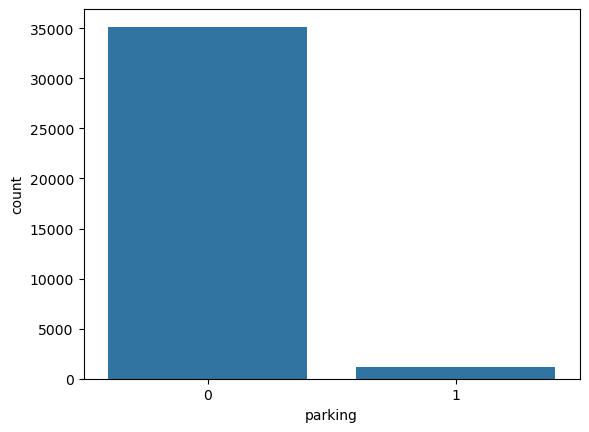

In [12]:
# parking
sns.countplot(data = df,x = 'parking')

#### As shown on the chart above, the parking column is binary (0 for no, 1 for yes), and the most of customers did not request for a parking space. This indicates that the hotel can potential create more revenues by renting the some of the vacant parking space to outsiders other than customers to increase revenue per squared meter. 

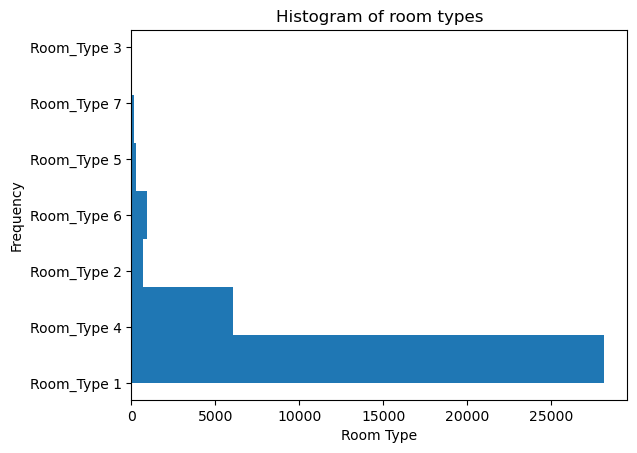

In [15]:
# room_type
plt.hist(df['room_type'], bins=7, orientation = 'horizontal') 
plt.title('Histogram of room types')
plt.xlabel('Room Type')
plt.ylabel('Frequency')
plt.show()

#### As shown in the chart above, the room_type column can take 7 different values. The majority of customers chose Room Type 1; some customers chose Room Type 4; and least people has chosen Room Type 3, which makes sense as in a typical hotel some room types (e.g. double) are chosen more often than others (e.g. penthouse suite). 

<Axes: xlabel='meal_plan', ylabel='count'>

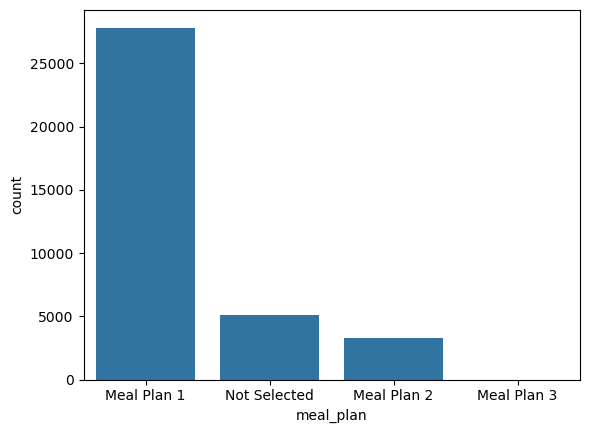

In [15]:
# meal_type
sns.countplot(data = df,x = 'meal_plan')

#### There are 4 unique values for the meal_plan column, among them most customers chose Meal Plan 1 and least people chose Meal Plan 3. In terms of operation efficiency, the hotel can adjust the relevant inventory level for each meal plan according to the frequency shown on the chart above. 

<Axes: xlabel='arrival_year', ylabel='count'>

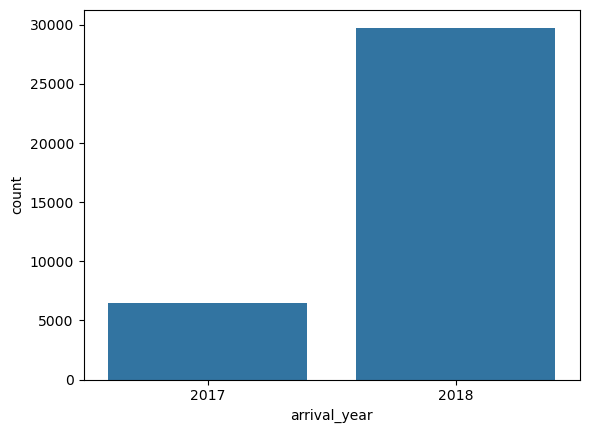

In [24]:
# arrival_year
sns.countplot(data = df,x = 'arrival_year')

#### The chart above shows bookings based on arrival year. Most of the records in this dataset are from 2018. 

<Axes: xlabel='arrival_month', ylabel='count'>

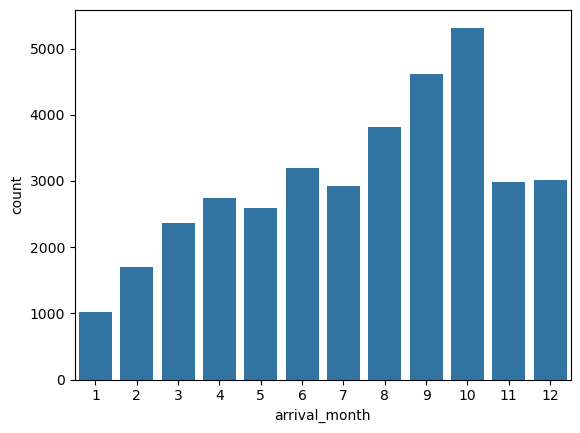

In [27]:
# arrival_month
sns.countplot(data = df,x = 'arrival_month')

#### The chart above shows the records of booking by arrival months. We noticed some seasonal peaks which can potentially take a closer look at in next section. For months with less bookings (Jan and Feb), the hotel can consider providing off-peak promotions to increase occupancy rates. 

<Axes: xlabel='arrival_date', ylabel='count'>

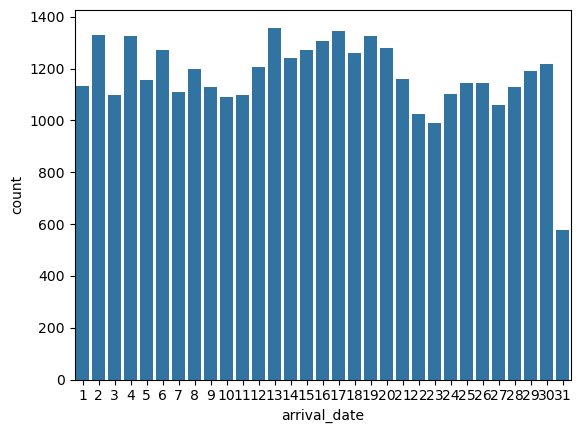

In [28]:
# arrival_date
sns.countplot(data = df,x = 'arrival_date')

#### The chart above shows the bookings by arrival dates. The day with least bookings is 31th, but considering that some months only have 30 days, the day with least bookings is in fact 23th. Therefore, if monthly maintenance is needed to conduct, the 23th day of the month is a good choice as this will affect the least customers. 

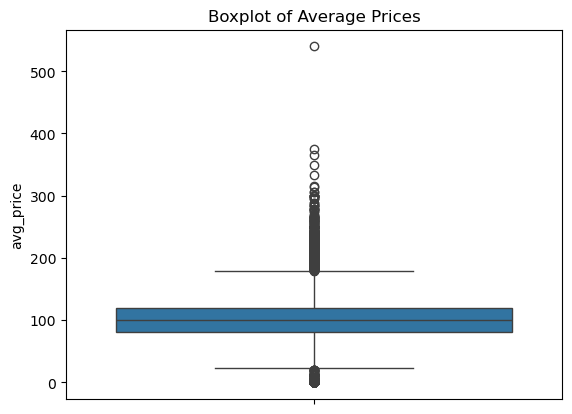

       no_of_adults  no_of_children  weekend_nights   week_nights  \
count  36275.000000    36275.000000    36275.000000  36275.000000   
mean       1.844962        0.105279        0.810724      2.204300   
std        0.518715        0.402648        0.870644      1.410905   
min        0.000000        0.000000        0.000000      0.000000   
25%        2.000000        0.000000        0.000000      1.000000   
50%        2.000000        0.000000        1.000000      2.000000   
75%        2.000000        0.000000        2.000000      3.000000   
max        4.000000       10.000000        7.000000     17.000000   

               meal       parking          room     lead_time           mkt  \
count  36275.000000  36275.000000  36275.000000  36275.000000  36275.000000   
mean       0.949966      0.030986      1.708890     85.232557      0.804604   
std        0.480191      0.173281      1.399851     85.930817      0.646881   
min        0.000000      0.000000      1.000000      0.000000 

In [41]:
df_num = df[['no_of_adults','no_of_children','weekend_nights','week_nights','meal','parking','room','lead_time','mkt','repeated_guest','prev_cancellations','prev_bookings','avg_price','special_requests']]

# Histogram to visualize discrete columns' distribution
#for i in df_num.columns:
    #plt.hist(df_num[i], bins=20) 
    #plt.title(f'Histogram of {i}')
    #plt.xlabel(i)
    #plt.ylabel('Frequency')
    #plt.show()

# Boxplot to visualiza continuous data's distribution
sns.boxplot(data=df['avg_price'])
plt.xticks(rotation=45)
plt.title('Boxplot of Average Prices')
plt.show()

# Summary statistics to identify potential outliers
summary_stats = df_num.describe()
print(summary_stats)

#### Examine whether there are outliers for numeric columns

In [42]:
# Interquartile Range (IQR) to identify outliers in average prices
Q1 = df['avg_price'].quantile(0.25)
Q3 = df['avg_price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_iqr = df[((df['avg_price'] < lower_bound) | (df['avg_price'] > upper_bound))]
print("Outliers based on IQR:")
print(outliers_iqr)

Outliers based on IQR:
      Booking_ID  no_of_adults  no_of_children  weekend_nights  week_nights  \
60      INN00061             2               2               0            1   
63      INN00064             1               0               0            1   
114     INN00115             2               2               2            2   
127     INN00128             2               2               0            2   
145     INN00146             1               0               0            2   
...          ...           ...             ...             ...          ...   
36221   INN36222             2               2               2            4   
36227   INN36228             2               2               0            1   
36250   INN36251             1               0               0            2   
36263   INN36264             1               0               2            1   
36269   INN36270             2               2               0            1   

         meal_plan  parking 

In [43]:
# Drop outliers from the original DataFrame
df = df.drop(outliers_iqr.index)
#df.shape
#df_cont = df[['no_of_children','no_of_adults','weekend_nights','week_nights','lead_time','avg_price']]
#for col in df_cont.columns:
    #print('The mean of ' + col + ' is: ' + str(np.mean(df[col])) + ', and its standard deviation is: ' + str(np.std(df[col])))
#tmp = df[(df['no_of_children'] <= np.mean(df['no_of_children']) + 3 * np.std(df['no_of_children'])) & (df['no_of_adults'] <= np.mean(df['no_of_adults']) + 3 * np.std(df['no_of_adults'])) & (df['weekend_nights'] <= np.mean(df['weekend_nights']) + 3 * np.std(df['weekend_nights'])) & (df['week_nights'] <= np.mean(df['week_nights']) + 3 * np.std(df['week_nights'])) & (df['lead_time'] <= np.mean(df['lead_time']) + 3 * np.std(df['lead_time'])) & (df['avg_price'] <= np.mean(df['avg_price']) + 3 * np.std(df['avg_price']))]
#print('If we delete data that are 3 standard deviation away from the mean, the number of rows we will lose is: ' + str(len(df) - len(tmp)) + ', and it is ' + str((len(df) - len(tmp))/len(df)) + ' of the original dataset')

In [24]:
#df = tmp

## Data Analysis

In [44]:
## Are the cancel rates for customers with different room types different statistically? 
room_ANOVA = ols('cancel ~ room', data=df).fit()
anova_table1 = sm.stats.anova_lm(room_ANOVA, typ=2)
print(anova_table1)

               sum_sq       df          F    PR(>F)
room         2.601821      1.0  11.744967  0.000611
Residual  7659.719183  34577.0        NaN       NaN


#### As shown in the table above, the p-value for room (room_type) variables is 0.0006, which is way less than 0.05, therefore, we can conclude that the cancel rates for customers with different room types are statistically inconsistent (different), which is also evident based on the chart below.

<Axes: xlabel='booking_status', ylabel='count'>

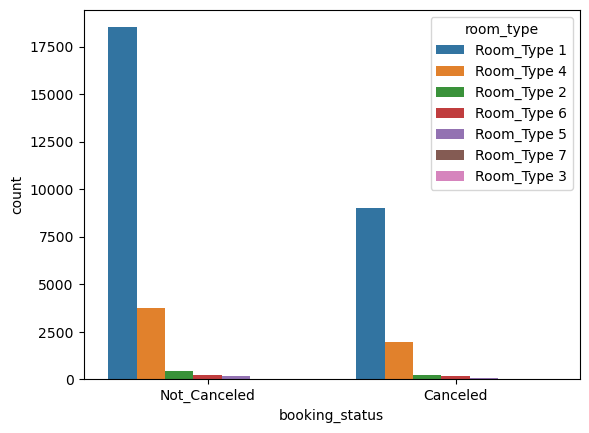

In [45]:
# cancel counts vs room_type
sns.countplot(data = df,x = 'booking_status',hue = 'room_type')

In [46]:
## Now, let's see whether the room type is correlated with booking status, and if so, the direction of such correlation
pearsonr_room, p_value_room = pearsonr(df['room'], df['cancel'])
print("Correlation coefficient between arrival month and booking status:", pearsonr_room)
print("P-value for the correlation:", p_value_room)

Correlation coefficient between arrival month and booking status: 0.01842716414103142
P-value for the correlation: 0.0006107895826428503


#### A Pearson's r of 0.0184 indicates that booking status is slightly positively correlated with room type, and p-value is 0.00061, which is less than 0.05, therefore we **WILL** use it as independent variable for our model.

In [47]:
## Do those who bring their children with them honor their reservation more than those who do not?
child_ANOVA = ols('cancel ~ no_of_children', data=df).fit()
anova_table2 = sm.stats.anova_lm(child_ANOVA, typ=2)
print(anova_table2)

                     sum_sq       df          F   PR(>F)
no_of_children     3.107487      1.0  14.028537  0.00018
Residual        7659.213518  34577.0        NaN      NaN


#### As shown in the table above, the p-value for children (no_of_children) variables is 0.00018, which is less than 0.05, therefore, we can conclude that the cancel rates for customers who bring different numbers of children with them are statistically unconsistent (different).

In [48]:
## Now, let's see whether the no_of_children is correlated with booking status, and if so, the direction of such correlation
pearsonr_child, p_value_child = pearsonr(df['no_of_children'], df['cancel'])
print("Correlation coefficient between arrival month and booking status:", pearsonr_child)
print("P-value for the correlation:", p_value_child)

Correlation coefficient between arrival month and booking status: 0.020138376457828996
P-value for the correlation: 0.00018034924350528915


#### A Pearson's r of 0.0201 indicates that booking status is slightly positively correlated with number of children, and the p-value is 0.00018, which is less than 0.05, therefore we **WILL** use it as independent variable for our model.

### Meanwhile, we wonder whether simply categorizing customers into two groups based on whether they bring children with them (instead of based on the number of child they bring) would yield different results.

In [49]:
pearsonr_bring_child, p_value_bring_child = pearsonr(df['bring_child'], df['cancel'])
print("Correlation coefficient between arrival month and booking status:", pearsonr_bring_child)
print("P-value for the correlation:", p_value_bring_child)

Correlation coefficient between arrival month and booking status: 0.01683952917970912
P-value for the correlation: 0.001739207590244245


#### A Pearson's r of 0.0168 indicates that booking status is slightly positively correlated with whether a customer brings child, and the p-value is less than 0.05, but it is greater than the p-value in cell 48, therefore we **WILL NOT** use it as independent variable for our model.

In [50]:
## Is there seasonality for cancel rate? (Whether cancel rate are inconsistent throughout a year) 
month_ANOVA = ols('cancel ~ arrival_month', data=df).fit()
anova_table3 = sm.stats.anova_lm(month_ANOVA, typ=2)
print(anova_table3)

                    sum_sq       df         F    PR(>F)
arrival_month     0.422800      1.0  1.908033  0.167191
Residual       7661.898204  34577.0       NaN       NaN


#### As shown in the table above, the p-value for month (arrival_month) variables is 0.167, which is greater than 0.05, therefore, we **cannot** conclude that the cancel rates for customers arrived in different months of a year are statistically inconsistent (different).

In [51]:
## Now, let's see whether the room type is correlated with booking status, and if so, the direction of such correlation
pearsonr_month, p_value_month = pearsonr(df['arrival_month'], df['cancel'])
print("Correlation coefficient between arrival month and booking status:", pearsonr_month)
print("P-value for the correlation:", p_value_month)

Correlation coefficient between arrival month and booking status: -0.0074282629496287556
P-value for the correlation: 0.16719088004722232


#### A Pearson's r of -0.0074 indicates that booking status is slightly negatively correlated with arrival months, and the p-value is 0.167, which is greater than 0.05, therefore, it **WILL NOT** be considered as an independent variable for our model.

### Meanwhile, we wonder whether categorizing customers into 4 groups based on the season they arrived (spring,summer,fall,winter) would yield a more statistically significant result (a smaller p-value).

In [52]:
pearsonr_season, p_value_season = pearsonr(df['season'], df['cancel'])
print("Correlation coefficient between season and booking status:", pearsonr_season)
print("P-value for the correlation:", p_value_season)

Correlation coefficient between season and booking status: -0.12059438815763546
P-value for the correlation: 3.5919437300020967e-112


#### A Pearson's r of -0.1206 indicates that booking status is slightly negatively correlated with arrival season, and the p-value is 3.592*e-112, which is way less than 0.05, therefore, we **WILL** use season as an independent variable for our model instead of months.

### We also want to examine whether the cancel rates are influenced by the year.

In [53]:
## Is the cancel rate in 2017 different from 2018? 
cancel_rates_2017 = df[df['arrival_year'] == 2017]['cancel'].mean()
cancel_rates_2018 = df[df['arrival_year'] == 2018]['cancel'].mean()

# Perform t-test to check for significant difference
t_stat, p_value = ttest_ind(df[df['arrival_year'] == 2017]['cancel'], 
                            df[df['arrival_year'] == 2018]['cancel'])

# Print cancellation rates and p-value
print("Cancellation rate in 2017:", cancel_rates_2017)
print("Cancellation rate in 2018:", cancel_rates_2018)
print("P-value for the t-test:", p_value)

Cancellation rate in 2017: 0.15001627074520013
Cancellation rate in 2018: 0.3706608518271023
P-value for the t-test: 2.1786386495439303e-247


#### Since p-value of the t-test is very small and much less than 0.05, so at significantce level 5%, we can reject the null hypothesis and conclude that cancel rate in 2017 is significantly different from that in 2018.

In [54]:
# check correlation with cancel status
pearsonr_year, p_value_year = pearsonr(df['arrival_year'], df['cancel'])
print("Correlation coefficient between arrival year and booking status:", pearsonr_year)
print("P-value for the correlation:", p_value_year)

Correlation coefficient between arrival year and booking status: 0.17919030157570132
P-value for the correlation: 2.178638649547044e-247


#### A Pearson's r of 0.179 indicates that booking status is slightly positively correlated with arrival year. P-value being less than 0.05 indicates that this correlation between year and cancel status is significant at 5% level.

### Generally check whether the DVs are correlated with IV:

In [55]:
# Define independent variables (features) and dependent variable (outcome)
X1 = df[['no_of_adults','no_of_children','weekend_nights','week_nights','meal','parking','room','lead_time','arrival_year','arrival_month','arrival_date','mkt','repeated_guest','prev_cancellations','prev_bookings','avg_price','special_requests']]
y1 = df['cancel'] 

# Calculate pearsonr correlation coefficient for each independent variable
correlation_coefficients = []
for col in X1.columns:
    corr_coef, p_value = pearsonr(X1[col], y1)
    correlation_coefficients.append((col, corr_coef, p_value))
correlation_df = pd.DataFrame(correlation_coefficients, columns=['Independent Variable', 'Correlation Coefficient', 'P-value'])
print(correlation_df)

   Independent Variable  Correlation Coefficient        P-value
0          no_of_adults                 0.080543   7.206377e-51
1        no_of_children                 0.020138   1.803492e-04
2        weekend_nights                 0.054285   5.437441e-24
3           week_nights                 0.082085   9.022263e-53
4                  meal                 0.047471   1.027408e-18
5               parking                -0.084108   2.524262e-55
6                  room                 0.018427   6.107896e-04
7             lead_time                 0.440703   0.000000e+00
8          arrival_year                 0.179190  2.178639e-247
9         arrival_month                -0.007428   1.671909e-01
10         arrival_date                 0.009275   8.459203e-02
11                  mkt                -0.013115   1.473232e-02
12       repeated_guest                -0.101599   5.236608e-80
13   prev_cancellations                -0.031149   6.893062e-09
14        prev_bookings                -

#### As suggested from the table above, all our independent variables except for arrival_month and arrival_date have significant correlations with our dependent variable since p-values are all smaller than 5%. The top three strongly correlated factors are Number of days between the date of booking and the arrival date (lead_time), Total number of special requests made by the customer(special_requests), and Year of arrival date(arrival_year).

## Data Visualization (draw it when needed)

## Modeling

Check assumptions of logistic regression:

1. Binary Outcome: The outcome variable(cancel) is binary, 1 for canceled, 0 for not.
2. Independence of Observations: Each observation(row) is a unique booking.
3. Large Sample Size: Our dataset has 36275 rows of data.
4. No Outliers: We checked outliers at the beginning of the project.

Check no multicolinearity between independent variables:

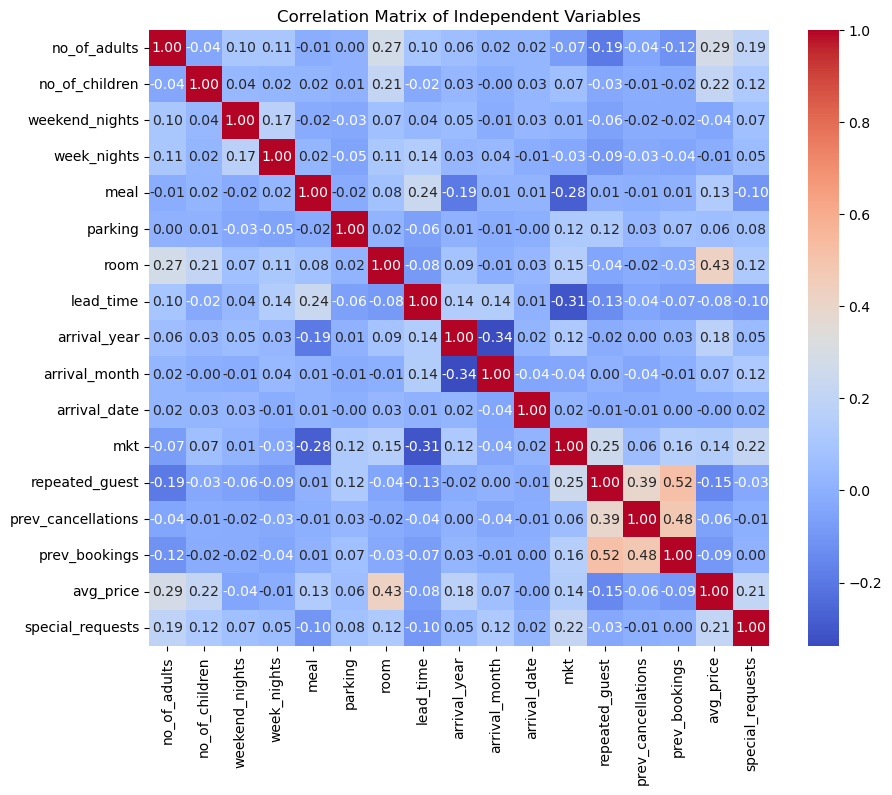

In [57]:
# Calculate correlation matrix
correlation_matrix = X1.corr()

# Plot correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Independent Variables')
plt.show()

In [58]:
## predictive model for whether a customer, given information about the booking, would honor or cancel the reservation
X2 = df[['no_of_children','no_of_adults','weekend_nights','week_nights','meal','parking','lead_time','arrival_year','season','mkt','repeated_guest','prev_cancellations','prev_bookings','avg_price','special_requests']]
# train-test split to avoid overfitting
X_train, X_test, y_train, y_test = train_test_split(X2, y1, test_size=0.2, random_state=9)

# fit the Model
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

coefficients = model.coef_[0]
intercept = model.intercept_
coefficients_df = pd.DataFrame({'Feature': X2.columns, 'Coefficient': coefficients})
print("Intercept:", intercept)
print("\nCoefficients:")
print(coefficients_df)

Accuracy: 0.7849913244650086
Intercept: [-0.00018903]

Coefficients:
               Feature  Coefficient
0       no_of_children     0.006104
1         no_of_adults     0.046238
2       weekend_nights     0.216234
3          week_nights     0.056581
4                 meal    -0.480900
5              parking    -0.148728
6            lead_time     0.015134
7         arrival_year    -0.002019
8               season    -0.132176
9                  mkt     0.706116
10      repeated_guest    -0.060232
11  prev_cancellations    -0.006183
12       prev_bookings    -0.215319
13           avg_price     0.023529
14    special_requests    -1.318211


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
